## 数据清洗

In [1]:
#先导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
#读取数据
df = pd.read_csv('./data/sh600132.csv')
 
#查看描述统计
df.describe().style.background_gradient(cmap = 'Oranges')

,open,high,low,close,old_close,volume,amount,active_value,total_value
count,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000
mean,37.248133,38.071561,36.500476,37.308433,37.293123,3937029.426638,155839979.093823,15012504542.588766,16271645986.629221
std,36.207685,37.078078,35.390398,36.254985,36.254894,5743958.925658,228945773.517893,19246225075.687870,18523934902.380821
min,6.490000,6.890000,6.450000,6.550000,5.540000,9800.000000,116644.000000,324000000.000000,1413000000.000000
25%,15.700000,15.940000,15.490000,15.720000,15.715000,923722.000000,13165877.500000,1078220000.000000,3609671000.000000
50%,21.500000,21.900000,21.040000,21.560000,21.560000,2728464.000000,74908041.000000,7632225792.000000,8798596380.000000
75%,43.580000,44.750000,42.550000,43.760000,43.675000,4689830.000000,198805554.000000,20278393196.000000,20278393196.000000
max,204.000000,209.990000,201.020000,205.030000,205.030000,93487135.000000,2992033108.000000,99228614726.000000,99228614726.000000


## 添加股票指标

#### MADC

In [2]:
# 计算12日EMA和26日EMA
df["EMA12"] = df["close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["close"].ewm(span=26, adjust=False).mean()

# 计算 DIF（快线）
df["DIF"] = df["EMA12"] - df["EMA26"]

# 计算 DEA（慢线），即 DIF 的 9 日 EMA
df["DEA"] = df["DIF"].ewm(span=9, adjust=False).mean()

# 计算 MACD 直方图
df["MACD"] = 2 * (df["DIF"] - df["DEA"])

# 删除中间计算过程中的列，只保留 MACD 列
df = df.drop(columns=["EMA12", "EMA26", "DIF", "DEA"])

# 显示结果
print(df[["date", "close", "MACD"]].head())

         date  close      MACD
0  1997/10/30  12.12  0.000000
1  1997/10/31  11.32 -0.102108
2   1997/11/3  10.95 -0.207747
3   1997/11/4  11.12 -0.240665
4   1997/11/5  10.88 -0.278059


#### RSI

In [3]:
# 计算每日涨跌
df["delta"] = df["close"].diff()

# 计算涨跌幅 (up / down)
df["up"] = df["delta"].apply(lambda x: x if x > 0 else 0)
df["down"] = df["delta"].apply(lambda x: -x if x < 0 else 0)

# 计算 6 日平均涨跌幅
df["avg_up"] = df["up"].rolling(window=6).mean()
df["avg_down"] = df["down"].rolling(window=6).mean()

# 避免除零错误
df["R6"] = df["avg_up"] / df["avg_down"].replace(0, 1)

# 计算 RSI6
df["RSI6"] = 100 - (100 / (1 + df["R6"]))

# 删除中间计算列，只保留 MACD 和 RSI6
df = df.drop(columns=[ "delta", "up", "down", "avg_up", "avg_down", "R6"])

# 显示结果
print(df[["date", "MACD", "RSI6"]][:10])

         date      MACD       RSI6
0  1997/10/30  0.000000        NaN
1  1997/10/31 -0.102108        NaN
2   1997/11/3 -0.207747        NaN
3   1997/11/4 -0.240665        NaN
4   1997/11/5 -0.278059        NaN
5   1997/11/6 -0.263334  19.428571
6   1997/11/7 -0.235259  20.338983
7  1997/11/10 -0.262293  25.000000
8  1997/11/11 -0.300156  26.277372
9  1997/11/12 -0.339583  12.837838


#### ＭＡ

In [5]:
# 计算 5 日移动平均线 (MA5)
df["MA5"] = df["close"].rolling(window=5, min_periods=1).mean()

# 计算 10 日移动平均线 (MA10)
df["MA10"] = df["close"].rolling(window=10, min_periods=1).mean()

print(df[["date", "close", "MA5", "MA10"]].head(10))


         date  close        MA5       MA10
0  1997/10/30  12.12  12.120000  12.120000
1  1997/10/31  11.32  11.720000  11.720000
2   1997/11/3  10.95  11.463333  11.463333
3   1997/11/4  11.12  11.377500  11.377500
4   1997/11/5  10.88  11.278000  11.278000
5   1997/11/6  11.05  11.064000  11.240000
6   1997/11/7  11.07  11.014000  11.215714
7  1997/11/10  10.60  10.944000  11.138750
8  1997/11/11  10.30  10.780000  11.045556
9  1997/11/12  10.02  10.608000  10.943000


#### KDJ

In [6]:
# 计算 RSV9
df["lowest_9"] = df["low"].rolling(window=9, min_periods=1).min()
df["highest_9"] = df["high"].rolling(window=9, min_periods=1).max()
df["RSV9"] = (df["close"] - df["lowest_9"]) / (df["highest_9"] - df["lowest_9"]) * 100

# 初始化 K 和 D
df["K"] = 50
df["D"] = 50

# 计算 K, D, J
for i in range(1, len(df)):
    df.loc[i, "K"] = df.loc[i-1, "K"] * 2/3 + df.loc[i, "RSV9"] * 1/3
    df.loc[i, "D"] = df.loc[i-1, "D"] * 2/3 + df.loc[i, "K"] * 1/3

df["J"] = 3 * df["K"] - 2 * df["D"]

print(df[["date", "close", "K", "D", "J"]].head(10))

         date  close          K          D          J
0  1997/10/30  12.12  50.000000  50.000000  50.000000
1  1997/10/31  11.32  37.596899  45.865633  21.059432
2   1997/11/3  10.95  26.756647  39.495971   1.277999
3   1997/11/4  11.12  23.118293  34.036745   1.281388
4   1997/11/5  10.88  17.505593  28.526361  -4.535943
5   1997/11/6  11.05  16.501313  24.518012   0.467916
6   1997/11/7  11.07  16.153854  21.729959   5.001645
7  1997/11/10  10.60  12.067938  18.509285  -0.814758
8  1997/11/11  10.30  11.378625  16.132399   1.871078
9  1997/11/12  10.02   7.952050  13.405616  -2.955080


#### CCI

In [7]:
# 计算 CCI（顺势指标）
df["TP"] = (df["high"] + df["low"] + df["close"]) / 3  # 计算典型价格
df["SMA_TP"] = df["TP"].rolling(window=14, min_periods=1).mean()  # 14日 TP 均值
df["MAD_TP"] = df["TP"].rolling(window=14, min_periods=1).apply(lambda x: abs(x - x.mean()).mean(), raw=True)  # 14日偏差的均值
df["CCI"] = (df["TP"] - df["SMA_TP"]) / (0.015 * df["MAD_TP"])

# 删除中间计算列，只保留所需列
df = df.drop(columns=["TP", "SMA_TP", "MAD_TP"])



print(df[["date", "close", "CCI"]].head(10))

         date  close         CCI
0  1997/10/30  12.12         NaN
1  1997/10/31  11.32  -66.666667
2   1997/11/3  10.95  -75.742574
3   1997/11/4  11.12  -62.982273
4   1997/11/5  10.88  -70.508397
5   1997/11/6  11.05  -52.777778
6   1997/11/7  11.07  -42.063821
7  1997/11/10  10.60  -89.442623
8  1997/11/11  10.30 -162.585034
9  1997/11/12  10.02 -151.795430


#### MTM

In [8]:
# 计算动量指标 MTM
df["MTM"] = df["close"] - df["close"].shift(6)

# 显示前 10 行数据
print(df[["date", "close", "MTM"]].head(10))

         date  close   MTM
0  1997/10/30  12.12   NaN
1  1997/10/31  11.32   NaN
2   1997/11/3  10.95   NaN
3   1997/11/4  11.12   NaN
4   1997/11/5  10.88   NaN
5   1997/11/6  11.05   NaN
6   1997/11/7  11.07 -1.05
7  1997/11/10  10.60 -0.72
8  1997/11/11  10.30 -0.65
9  1997/11/12  10.02 -1.10


#### BIAS

In [9]:
# 计算 12 日简单移动平均线 MA12
df["MA12"] = df["close"].rolling(window=12, min_periods=1).mean()

# 计算乖离率 BIAS
df["BIAS"] = (df["close"] - df["MA12"]) / df["MA12"] * 100

df = df.drop(columns=["MA12"])

# 显示前 10 行数据  
print(df[["date", "close", "BIAS"]].head(10))

         date  close      BIAS
0  1997/10/30  12.12  0.000000
1  1997/10/31  11.32 -3.412969
2   1997/11/3  10.95 -4.478046
3   1997/11/4  11.12 -2.263239
4   1997/11/5  10.88 -3.528995
5   1997/11/6  11.05 -1.690391
6   1997/11/7  11.07 -1.299198
7  1997/11/10  10.60 -4.836719
8  1997/11/11  10.30 -6.749824
9  1997/11/12  10.02 -8.434616


#### OBV

In [10]:
# 初始化 OBV 列
df["OBV"] = 0

# 计算 OBV 值
for i in range(1, len(df)):
    if df.loc[i, "close"] > df.loc[i-1, "close"]:
        df.loc[i, "OBV"] = df.loc[i-1, "OBV"] + df.loc[i, "volume"]
    elif df.loc[i, "close"] < df.loc[i-1, "close"]:
        df.loc[i, "OBV"] = df.loc[i-1, "OBV"] - df.loc[i, "volume"]
    else:
        df.loc[i, "OBV"] = df.loc[i-1, "OBV"]

# 显示前 10 行数据
print(df[["date", "close", "volume", "OBV"]].head(10))

         date  close    volume       OBV
0  1997/10/30  12.12  21455500         0
1  1997/10/31  11.32   7439800  -7439800
2   1997/11/3  10.95   2411000  -9850800
3   1997/11/4  11.12   2161300  -7689500
4   1997/11/5  10.88   2709900 -10399400
5   1997/11/6  11.05   2545700  -7853700
6   1997/11/7  11.07   2047400  -5806300
7  1997/11/10  10.60   1631400  -7437700
8  1997/11/11  10.30   1965000  -9402700
9  1997/11/12  10.02   1424100 -10826800


#### PSY

In [11]:
# 计算12日内上涨的天数
df["Up_Days"] = (df["close"] > df["close"].shift(1)).astype(int)

# 计算12日内的心理线 PSY
df["PSY"] = df["Up_Days"].rolling(window=12).sum() / 12 * 100

# 删除中间列
df = df.drop(columns=["Up_Days"])

# 显示前 10 行数据
print(df[["date", "close", "PSY"]].head(20))

          date  close        PSY
0   1997/10/30  12.12        NaN
1   1997/10/31  11.32        NaN
2    1997/11/3  10.95        NaN
3    1997/11/4  11.12        NaN
4    1997/11/5  10.88        NaN
5    1997/11/6  11.05        NaN
6    1997/11/7  11.07        NaN
7   1997/11/10  10.60        NaN
8   1997/11/11  10.30        NaN
9   1997/11/12  10.02        NaN
10  1997/11/13  10.45        NaN
11  1997/11/14  10.23  33.333333
12  1997/11/17  10.07  33.333333
13  1997/11/18   9.76  33.333333
14  1997/11/19   9.70  33.333333
15  1997/11/20   9.56  25.000000
16  1997/11/21   9.21  25.000000
17  1997/11/24   9.16  16.666667
18  1997/11/25   9.27  16.666667
19  1997/11/26   9.52  25.000000


#### BOLL

In [12]:
# 计算20日移动平均线（MD）
df["MD"] = df["close"].rolling(window=20).mean()

# 计算20日标准差
df["STD"] = df["close"].rolling(window=20).std()

# 计算上轨线（UP）和下轨线（DN）
df["UP"] = df["MD"] + 2 * df["STD"]
df["DN"] = df["MD"] - 2 * df["STD"]

# 删除中间列
df = df.drop(columns=["STD"])

# 显示前 10 行数据
print(df[["date", "close", "MD", "UP", "DN"]].head(30))

          date  close       MD         UP        DN
0   1997/10/30  12.12      NaN        NaN       NaN
1   1997/10/31  11.32      NaN        NaN       NaN
2    1997/11/3  10.95      NaN        NaN       NaN
3    1997/11/4  11.12      NaN        NaN       NaN
4    1997/11/5  10.88      NaN        NaN       NaN
5    1997/11/6  11.05      NaN        NaN       NaN
6    1997/11/7  11.07      NaN        NaN       NaN
7   1997/11/10  10.60      NaN        NaN       NaN
8   1997/11/11  10.30      NaN        NaN       NaN
9   1997/11/12  10.02      NaN        NaN       NaN
10  1997/11/13  10.45      NaN        NaN       NaN
11  1997/11/14  10.23      NaN        NaN       NaN
12  1997/11/17  10.07      NaN        NaN       NaN
13  1997/11/18   9.76      NaN        NaN       NaN
14  1997/11/19   9.70      NaN        NaN       NaN
15  1997/11/20   9.56      NaN        NaN       NaN
16  1997/11/21   9.21      NaN        NaN       NaN
17  1997/11/24   9.16      NaN        NaN       NaN
18  1997/11/

In [13]:
df = df.dropna()
df = df.drop(columns=["id","date"])
print(df.head(10))

    open  high   low  close  old_close  volume   amount  active_value  \
19  9.32  9.52  9.23   9.52       9.27  596800  5595000     342720000   
20  9.40  9.49  9.00   9.10       9.52  576300  5295000     327600000   
21  9.00  9.43  8.90   9.38       9.10  632200  5815000     337680000   
22  9.38  9.38  9.11   9.19       9.38  370300  3409405     330840000   
23  9.10  9.26  9.10   9.17       9.19  301200  2767912     330120000   
24  9.17  9.17  8.99   9.00       9.17  403500  3641338     324000000   
25  9.01  9.35  8.92   9.25       9.00  490400  4490243     333000000   
26  9.30  9.35  9.01   9.10       9.25  548800  5029686     327600000   
27  9.11  9.48  9.11   9.40       9.10  676100  6329313     338400000   
28  9.39  9.50  9.27   9.50       9.40  493700  4633335     342000000   

    total_value      MACD  ...          D           J        CCI   MTM  \
19   1494640000 -0.136028  ...   9.970339   26.292626 -76.773762 -0.24   
20   1428700000 -0.122775  ...  10.822333   15.9

## 归一化处理

In [14]:
from sklearn.preprocessing import MinMaxScaler
# 对所有列进行归一化处理，将所有列的值归一化到 [0, 1]
# df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
scaler = MinMaxScaler(feature_range=(-1,1))
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# 显示前 10 行数据
print(df.head(10))

       open      high       low     close  old_close    volume    amount  \
0 -0.971343 -0.974101 -0.971424 -0.970073  -0.972592 -0.987441 -0.996338   
1 -0.970533 -0.974397 -0.973788 -0.974305  -0.970073 -0.987879 -0.996538   
2 -0.974584 -0.974988 -0.974816 -0.971483  -0.974305 -0.986683 -0.996191   
3 -0.970736 -0.975480 -0.972658 -0.973398  -0.971483 -0.992287 -0.997799   
4 -0.973571 -0.976662 -0.972760 -0.973599  -0.973398 -0.993765 -0.998228   
5 -0.972862 -0.977548 -0.973891 -0.975312  -0.973599 -0.991577 -0.997644   
6 -0.974482 -0.975775 -0.974611 -0.972793  -0.975312 -0.989717 -0.997076   
7 -0.971546 -0.975775 -0.973686 -0.974305  -0.972793 -0.988468 -0.996716   
8 -0.973470 -0.974495 -0.972658 -0.971282  -0.974305 -0.985744 -0.995847   
9 -0.970634 -0.974298 -0.971013 -0.970274  -0.971282 -0.989647 -0.996981   

   active_value  total_value      MACD  ...         D         J       CCI  \
0     -0.999621    -0.998331  0.135074  ... -0.853012 -0.291836 -0.108669   
1     -0.

## 

## 股指相关性分析

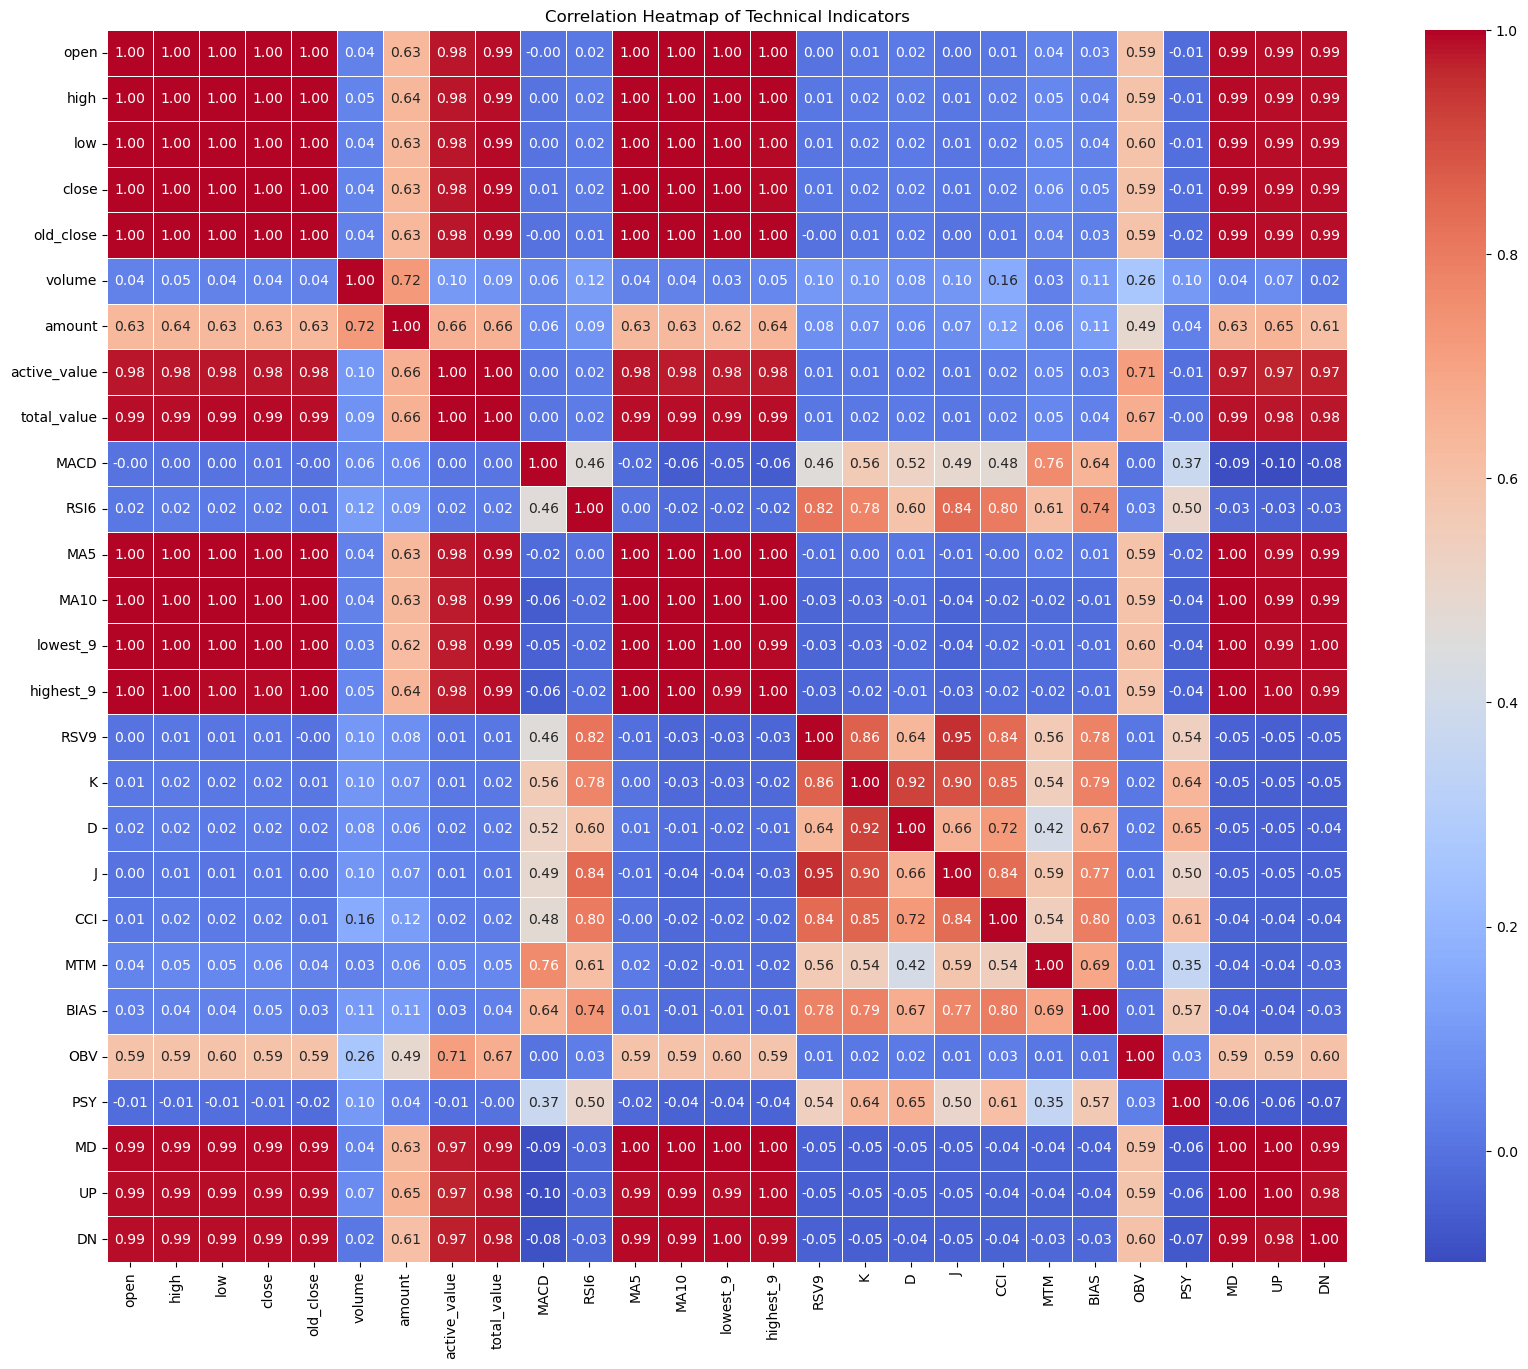

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


# 计算各指标之间的相关系数矩阵
corr_matrix = df.corr()

# 绘制热力图
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)

# 添加标题
plt.title("Correlation Heatmap of Technical Indicators")

# 显示图表
plt.show()

## PAC主成分分析

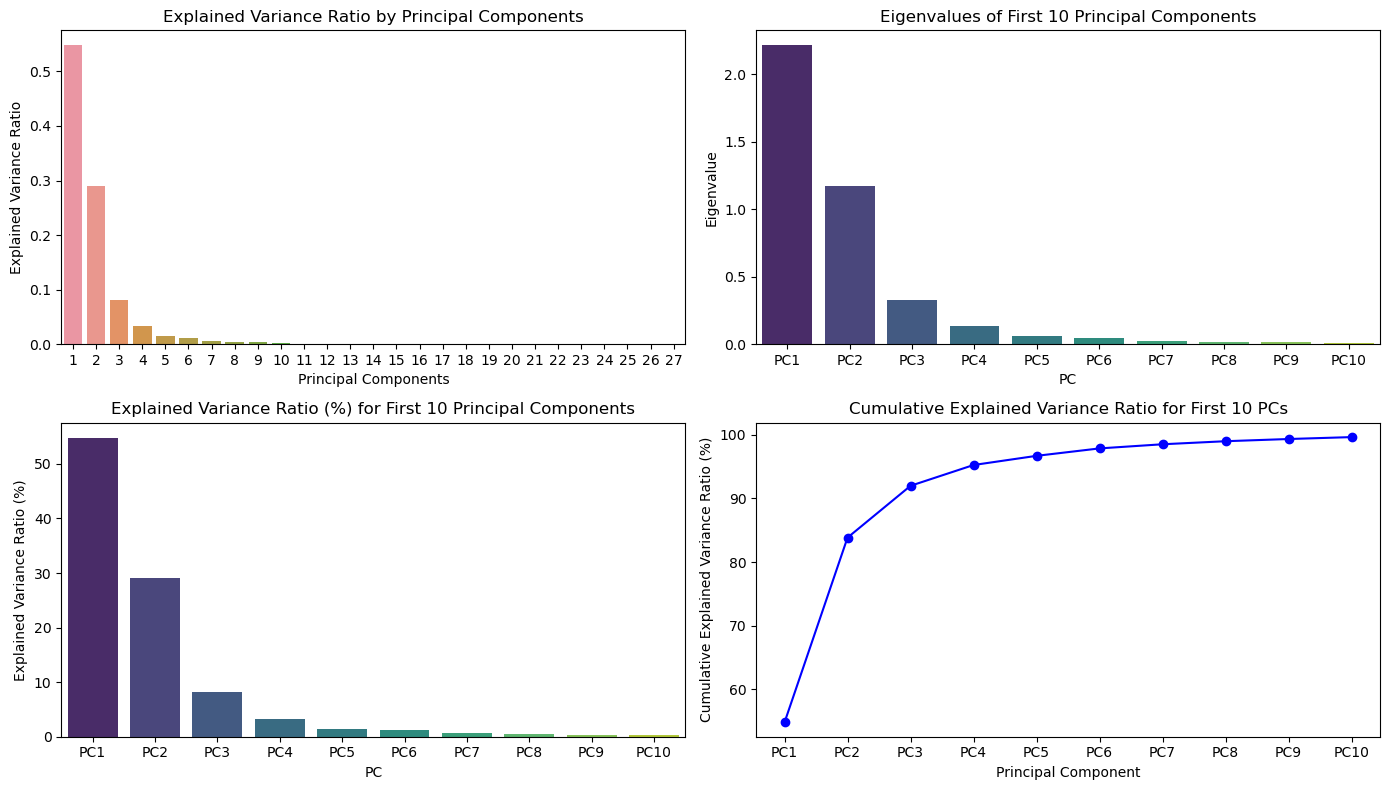

     PC  Eigenvalue  Explained Variance Ratio (%)  \
0   PC1    2.216128                     54.793864   
1   PC2    1.174873                     29.048788   
2   PC3    0.329494                      8.146764   
3   PC4    0.132129                      3.266896   
4   PC5    0.058390                      1.443707   
5   PC6    0.047221                      1.167538   
6   PC7    0.026281                      0.649806   
7   PC8    0.019380                      0.479164   
8   PC9    0.014036                      0.347030   
9  PC10    0.012132                      0.299960   

   Cumulative Explained Variance Ratio (%)  
0                                54.793864  
1                                83.842651  
2                                91.989416  
3                                95.256312  
4                                96.700019  
5                                97.867557  
6                                98.517364  
7                                98.996528  
8          

In [16]:
from sklearn.decomposition import PCA

# 执行PCA降维，保留所有主成分
pca = PCA()
pca_result = pca.fit_transform(df)

# 创建PCA结果的 DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=[f"PC{i+1}" for i in range(df.shape[1])])

# 设置图表样式
plt.figure(figsize=(14, 8))

# 可视化方差贡献，展示每个主成分的解释方差比例
plt.subplot(2, 2, 1)
sns.barplot(x=[f"{i+1}" for i in range(len(pca.explained_variance_ratio_))], y=pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')




# 获取特征值（Eigenvalues）和方差贡献率
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# 计算累计方差贡献率
cumulative_explained_variance = explained_variance_ratio.cumsum()

# 提取前10个主成分的数据
n_components = 10
components_data = {
    'PC': [f'PC{i+1}' for i in range(n_components)],
    'Eigenvalue': explained_variance[:n_components],
    'Explained Variance Ratio (%)': explained_variance_ratio[:n_components] * 100,
    'Cumulative Explained Variance Ratio (%)': cumulative_explained_variance[:n_components] * 100
}

# 创建DataFrame
components_df = pd.DataFrame(components_data)



# 绘制特征值条形图
plt.subplot(2, 2, 2)
sns.barplot(x='PC', y='Eigenvalue', data=components_df, palette="viridis")
plt.title('Eigenvalues of First 10 Principal Components')

# 绘制方差贡献率条形图
plt.subplot(2, 2, 3)
sns.barplot(x='PC', y='Explained Variance Ratio (%)', data=components_df, palette="viridis")
plt.title('Explained Variance Ratio (%) for First 10 Principal Components')

# 绘制累计方差贡献率折线图
plt.subplot(2, 2, 4)
plt.plot(components_df['PC'], components_df['Cumulative Explained Variance Ratio (%)'], marker='o', color='b')
plt.title('Cumulative Explained Variance Ratio for First 10 PCs')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio (%)')

# 适配布局并显示图形
plt.tight_layout()
plt.show()

# 输出前10主成分的数据
print(components_df)

          open          high           low         close     old_close  \
PC1   0.242446  2.413670e-01  2.406278e-01  2.415270e-01  2.416016e-01   
PC2  -0.006000 -8.088180e-03 -7.278570e-03 -9.285252e-03 -5.244681e-03   
PC3   0.111073  1.116828e-01  1.089118e-01  1.106660e-01  1.106264e-01   
PC4   0.011535  6.212901e-03  5.719996e-03  1.049032e-03  1.291472e-02   
PC5  -0.005977 -6.820291e-03 -4.726977e-03 -3.292019e-03 -5.713250e-03   
PC6  -0.006972  1.737436e-03 -9.425281e-04  7.206193e-03 -8.825359e-03   
PC7  -0.018522 -2.359147e-03 -2.612691e-02 -1.342591e-02 -1.957084e-02   
PC8  -0.065632 -7.222737e-02 -7.725142e-02 -8.165155e-02 -5.504668e-02   
PC9   0.005098 -5.336467e-03 -8.352867e-03 -1.035755e-02  1.320829e-02   
PC10 -0.012416  8.027750e-03  2.843666e-03  2.988068e-02 -1.440017e-02   
PC11 -0.000917 -4.558403e-03 -5.566767e-03 -2.555395e-03 -7.823620e-03   
PC12 -0.044333 -7.031489e-04 -1.696305e-02  2.221023e-02 -5.924583e-02   
PC13  0.075401  9.691123e-02  6.623874

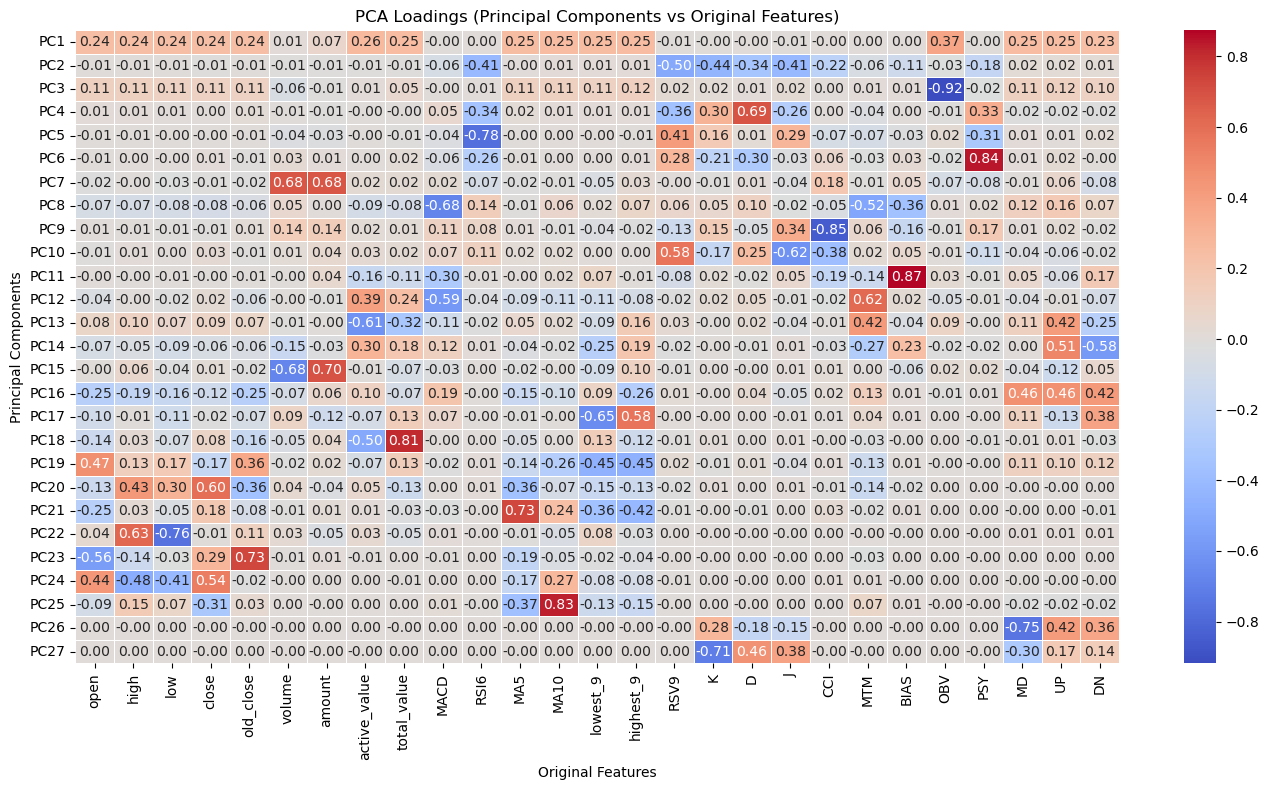

In [17]:
# 获取主成分的载荷矩阵
loadings = pca.components_

# 将载荷矩阵转换为DataFrame，方便查看和理解
loadings_df = pd.DataFrame(loadings, columns=df.columns, index=[f'PC{i+1}' for i in range(loadings.shape[0])])

# 显示载荷矩阵
print(loadings_df)

# 可视化载荷矩阵
plt.figure(figsize=(14, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PCA Loadings (Principal Components vs Original Features)')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.tight_layout()
plt.show()

## 分割训练集和测试集

In [21]:
from copy import deepcopy as dc
import torch

# 获取解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 获取前三个主成分（按解释方差比例选择）
top_3_components_indices = explained_variance_ratio.argsort()[-3:][::-1]  # 获取解释方差最多的3个主成分的索引

# 提取前3个主成分的数据
top_3_components = pca_result[:, top_3_components_indices]  # 选择对应的主成分列

print(top_3_components)




import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def create_sequences(data, target, seq_length=10):
    """
    创建时间序列序列，每个序列包含过去seq_length天的特征
    
    参数:
    data: 形状为(n_samples, n_features)的数组，包含主成分特征
    target: 形状为(n_samples,)的数组，包含收盘价
    seq_length: 序列长度，表示要考虑的过去几天
    
    返回:
    X: 形状为(n_samples-seq_length, seq_length, n_features)的数组
    y: 形状为(n_samples-seq_length,)的数组，对应每个序列的目标收盘价
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)


closing_prices = df['close'].values # 替换为您的收盘价数据，形状应为(n_samples,)

# 确保主成分数据和收盘价数据长度一致
assert len(top_3_components) == len(closing_prices), "主成分数据和收盘价数据长度必须一致"

# 创建序列数据，每个样本包含过去10天的3个主成分
X, y = create_sequences(top_3_components, closing_prices, seq_length=10)

# 按照时间顺序分割数据 - 前80%用于训练，后20%用于测试
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 打印数据集形状
print(f"原始主成分数据形状: {top_3_components.shape}")
print(f"序列化后的特征形状 X: {X.shape}")
print(f"目标值形状 y: {y.shape}")
print(f"训练集特征形状 X_train: {X_train.shape}")
print(f"训练集目标值形状 y_train: {y_train.shape}")
print(f"测试集特征形状 X_test: {X_test.shape}")
print(f"测试集目标值形状 y_test: {y_test.shape}")

# 确认数据适合CNN使用
print("\n数据准备就绪，可用于CNN模型训练")
print("每个样本包含过去10天的3个主成分，形状为: (10, 3)")


[[-1.34772704  1.25563788  0.46704962]
 [-1.34742358  1.6822958   0.45061427]
 [-1.3571177   0.95924089  0.46844908]
 ...
 [ 1.26764899  1.24146275 -0.59657266]
 [ 1.27344038  0.75021283 -0.58396353]
 [ 1.27132013  0.18363443 -0.56517961]]
原始主成分数据形状: (6408, 3)
序列化后的特征形状 X: (6398, 10, 3)
目标值形状 y: (6398,)
训练集特征形状 X_train: (5118, 10, 3)
训练集目标值形状 y_train: (5118,)
测试集特征形状 X_test: (1280, 10, 3)
测试集目标值形状 y_test: (1280,)

数据准备就绪，可用于CNN模型训练
每个样本包含过去10天的3个主成分，形状为: (10, 3)


## 模型构建

Epoch [10/100], Loss: 0.0042
Epoch [20/100], Loss: 0.0019
Epoch [30/100], Loss: 0.0009
Epoch [40/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0006
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0005
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0005

评估指标:
训练集 - RMSE: 0.013, MAE: 0.009, R²: 0.9902
测试集 - RMSE: 0.124, MAE: 0.093, R²: 0.8957


c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from c

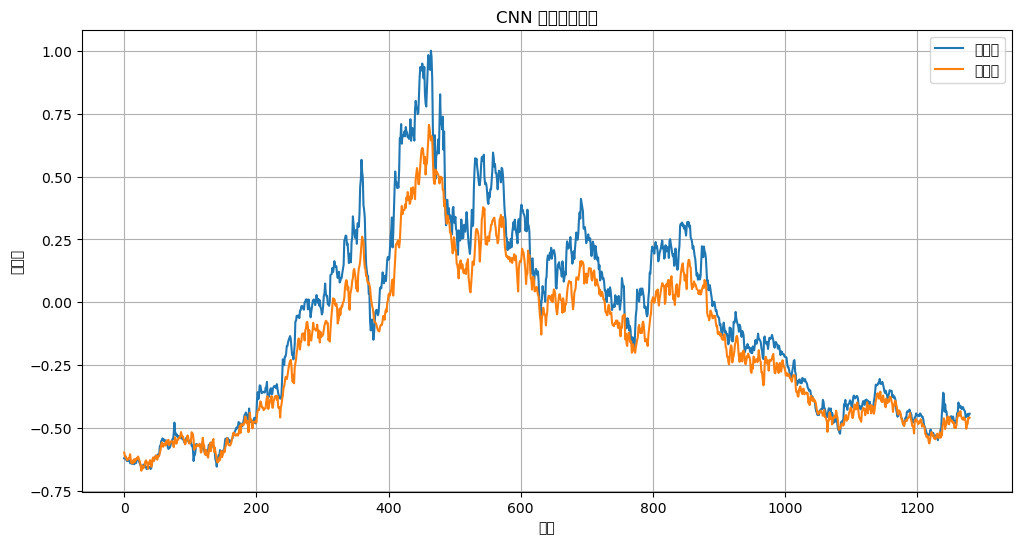

c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from c

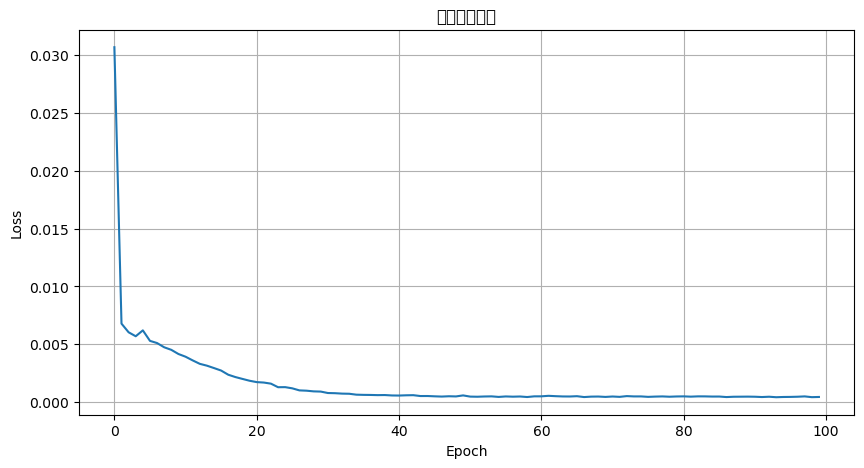

In [24]:
# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# 创建数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# 定义CNN模型
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 输入形状: (batch_size, 1, 10, 3) - 1是通道数，10是时间步，3是特征维度
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding=(1, 1))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=(1, 1))
        
        # 计算展平后的特征大小
        # 经过一次池化，时间维度变为10/2=5，特征维度保持为3
        # 第二层卷积后尺寸不变，但通道数变为32
        # 所以展平后的特征大小为 32 * 5 * 3 = 480
        self.fc1 = nn.Linear(32 * 5 * 3, 64)
        self.fc2 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # 假设输入x的形状为 (batch_size, 10, 3)
        # 需要添加一个通道维度
        x = x.unsqueeze(1)  # 变为 (batch_size, 1, 10, 3)
        
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        
        # 展平
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x.squeeze()  # 输出形状为 (batch_size,)

model = CNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # 计算每个epoch的平均损失
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# 评估模型
model.eval()
with torch.no_grad():
    # 对训练集进行预测
    train_predictions = model(X_train_tensor).numpy()
    
    # 对测试集进行预测
    test_predictions = model(X_test_tensor).numpy()

# 计算评估指标
train_rmse = math.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_rmse = math.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("\n评估指标:")
print(f"训练集 - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, R²: {train_r2:.4f}")
print(f"测试集 - RMSE: {test_rmse:.3f}, MAE: {test_mae:.3f}, R²: {test_r2:.4f}")

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='实际值')
plt.plot(test_predictions, label='预测值')
plt.legend()
plt.title('CNN 模型预测结果')
plt.xlabel('时间')
plt.ylabel('收盘价')
plt.grid(True)
plt.show()

# 可视化损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('训练损失曲线')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/150], Training Loss: 0.0026, Validation Loss: 0.0705
Epoch [20/150], Training Loss: 0.0015, Validation Loss: 0.0679
Epoch [30/150], Training Loss: 0.0010, Validation Loss: 0.0606
Epoch [40/150], Training Loss: 0.0006, Validation Loss: 0.0476
Epoch [50/150], Training Loss: 0.0004, Validation Loss: 0.0687
提前停止训练！Epoch 55

评估指标:
训练集 - RMSE: 0.015, MAE: 0.011, R²: 0.9861
测试集 - RMSE: 0.207, MAE: 0.132, R²: 0.7073


c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from c

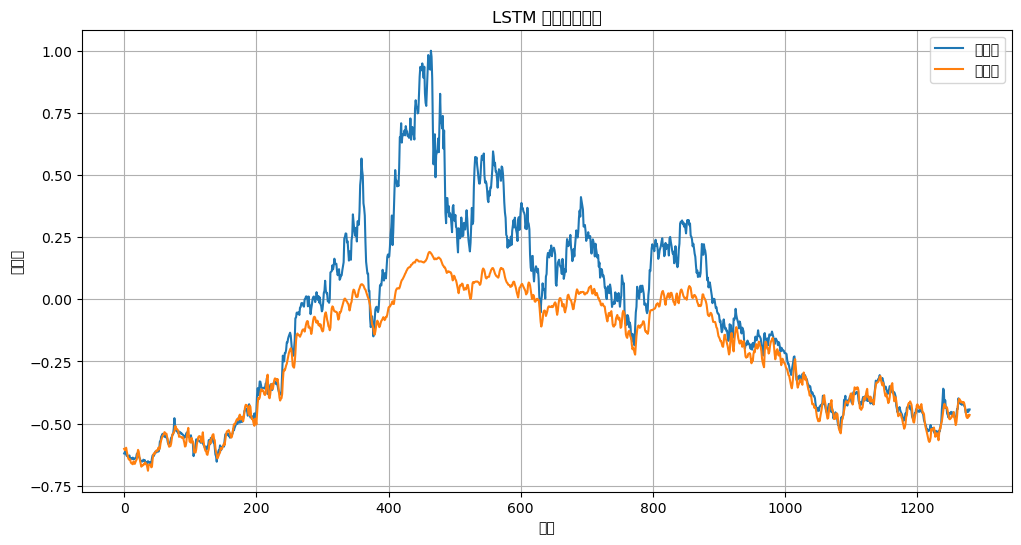

c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from c

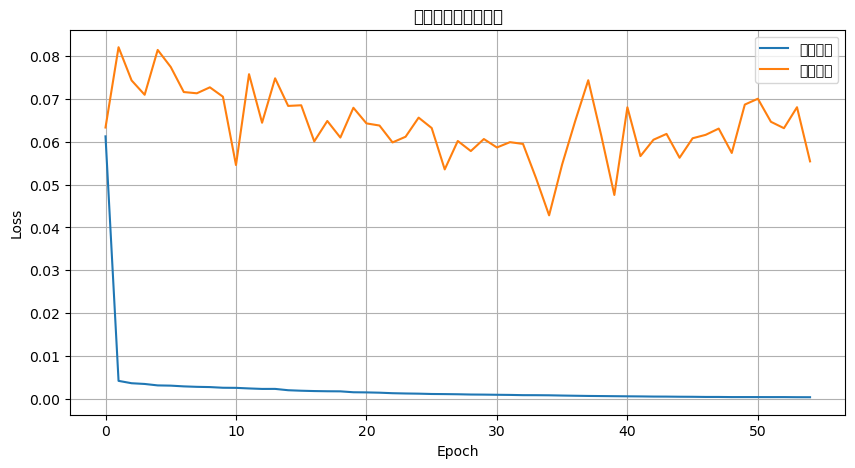

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2, dropout=0.2):
        """
        参数:
        input_size: 输入特征的维度，即每个时间步的特征数量（这里是3个主成分）
        hidden_size: LSTM隐藏层的大小
        num_layers: LSTM层的数量
        dropout: Dropout比率，用于防止过拟合
        """
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 全连接层，将LSTM的输出映射到预测值
        self.fc = nn.Linear(hidden_size, 1)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播LSTM
        # x的形状应为(batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # 我们只需要最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 应用dropout防止过拟合
        lstm_out = self.dropout(lstm_out)
        
        # 通过全连接层映射到输出
        output = self.fc(lstm_out)
        
        return output.squeeze()  # 输出形状为(batch_size,)
# 初始化模型、损失函数和优化器
model = LSTMModel(input_size=3, hidden_size=64, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 添加学习率调度器，随着训练进行逐渐降低学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# 训练模型
num_epochs = 150
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20  # 提前停止的轮数
patience_counter = 0

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
    
    # 计算每个epoch的平均训练损失
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # 验证阶段
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)
        
        # 更新学习率调度器
        scheduler.step(val_loss)
        
        # 提前停止
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), 'best_lstm_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'提前停止训练！Epoch {epoch+1}')
                break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

# 加载最佳模型
model.load_state_dict(torch.load('best_lstm_model.pth'))

# 评估模型
model.eval()
with torch.no_grad():
    # 对训练集进行预测
    train_predictions = model(X_train_tensor).numpy()
    
    # 对测试集进行预测
    test_predictions = model(X_test_tensor).numpy()

# 计算评估指标
train_rmse = math.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_rmse = math.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("\n评估指标:")
print(f"训练集 - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, R²: {train_r2:.4f}")
print(f"测试集 - RMSE: {test_rmse:.3f}, MAE: {test_mae:.3f}, R²: {test_r2:.4f}")

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='实际值')
plt.plot(test_predictions, label='预测值')
plt.legend()
plt.title('LSTM 模型预测结果')
plt.xlabel('时间')
plt.ylabel('收盘价')
plt.grid(True)
plt.show()

# 可视化训练和验证损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('训练和验证损失曲线')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/150], Training Loss: 0.0013, Validation Loss: 0.0324
Epoch [20/150], Training Loss: 0.0009, Validation Loss: 0.0313
Epoch [30/150], Training Loss: 0.0006, Validation Loss: 0.0311
Epoch [40/150], Training Loss: 0.0003, Validation Loss: 0.0415
提前停止训练！Epoch 48

评估指标:
训练集 - RMSE: 0.012, MAE: 0.008, R²: 0.9904
测试集 - RMSE: 0.156, MAE: 0.105, R²: 0.8337


c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from c

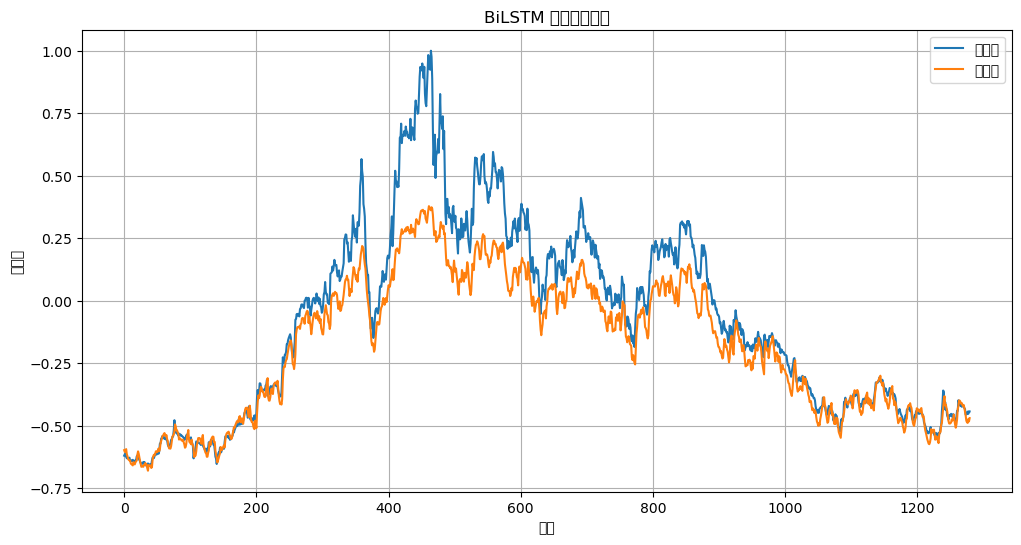

c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from c

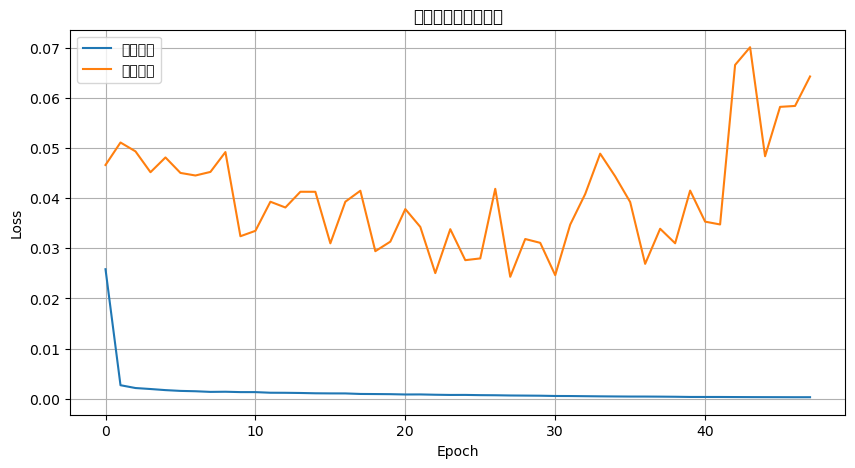

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# 定义BiLSTM模型
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2, dropout=0.2):
        """
        参数:
        input_size: 输入特征的维度，即每个时间步的特征数量（这里是3个主成分）
        hidden_size: LSTM隐藏层的大小
        num_layers: LSTM层的数量
        dropout: Dropout比率，用于防止过拟合
        """
        super(BiLSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 双向LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,  # 使用双向LSTM
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 由于是双向LSTM，输出维度翻倍，所以全连接层的输入维度要相应调整
        self.fc = nn.Linear(hidden_size * 2, 1)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        # 注意：由于是双向LSTM，隐藏状态的第一个维度需要乘以2
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播LSTM
        # x的形状应为(batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # 我们只需要最后一个时间步的输出
        # 由于是双向LSTM，输出包含了前向和后向的隐藏状态
        # lstm_out的形状为(batch_size, seq_len, hidden_size*2)
        lstm_out = lstm_out[:, -1, :]
        
        # 应用dropout防止过拟合
        lstm_out = self.dropout(lstm_out)
        
        # 通过全连接层映射到输出
        output = self.fc(lstm_out)
        
        return output.squeeze()  # 输出形状为(batch_size,)
model = BiLSTMModel(input_size=3, hidden_size=64, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 添加学习率调度器，随着训练进行逐渐降低学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# 训练模型
num_epochs = 150
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20  # 提前停止的轮数
patience_counter = 0

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
    
    # 计算每个epoch的平均训练损失
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # 验证阶段
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)
        
        # 更新学习率调度器
        scheduler.step(val_loss)
        
        # 提前停止
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), 'best_bilstm_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'提前停止训练！Epoch {epoch+1}')
                break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

# 加载最佳模型
model.load_state_dict(torch.load('best_bilstm_model.pth'))

# 评估模型
model.eval()
with torch.no_grad():
    # 对训练集进行预测
    train_predictions = model(X_train_tensor).numpy()
    
    # 对测试集进行预测
    test_predictions = model(X_test_tensor).numpy()

# 计算评估指标
train_rmse = math.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_rmse = math.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("\n评估指标:")
print(f"训练集 - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, R²: {train_r2:.4f}")
print(f"测试集 - RMSE: {test_rmse:.3f}, MAE: {test_mae:.3f}, R²: {test_r2:.4f}")

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='实际值')
plt.plot(test_predictions, label='预测值')
plt.legend()
plt.title('BiLSTM 模型预测结果')
plt.xlabel('时间')
plt.ylabel('收盘价')
plt.grid(True)
plt.show()

# 可视化训练和验证损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('训练和验证损失曲线')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\aoxiangxueyuan\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


CNNLSTMModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(96, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
模型总参数数量: 75137
Epoch [10/200], Training Loss: 0.0035, Validation Loss: 0.0753
Epoch [20/200], Training Loss: 0.0018, Validation Loss: 0.0419
Epoch [30/200], Training Loss: 0.0009, Validation Loss: 0.0101
Epoch [40/200], Training Loss: 0.0005, Validation Loss: 0.0462
Epoch [50/200], Training Loss: 0.0003, Validation Loss: 0.0251
提前停止训练！Epoch 55

评估指标:
训练集 - RMSE: 0.014, MAE: 0.009, R²: 0.9877
测试集 - RMSE: 0.100, MAE: 0.062, R²: 0.9311


D:\temp\ipykernel_19584\959715397.py:194: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig('cnn_lstm_prediction.png', dpi=300, bbox_inches='tight')
D:\temp\ipykernel_19584\959715397.py:194: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  plt.savefig('cnn_lstm_prediction.png', dpi=300, bbox_inches='tight')
D:\temp\ipykernel_19584\959715397.py:194: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.savefig('cnn_lstm_prediction.png', dpi=300, bbox_inches='tight')
D:\temp\ipykernel_19584\959715397.py:194: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig('cnn_lstm_prediction.png', dpi=300, bbox_inches='tight')
D:\temp\ipykernel_19584\959715397.py:194: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.savefig('cnn_lstm_prediction.png', dpi=300, bbox_inches='tight')
D:\temp\ip

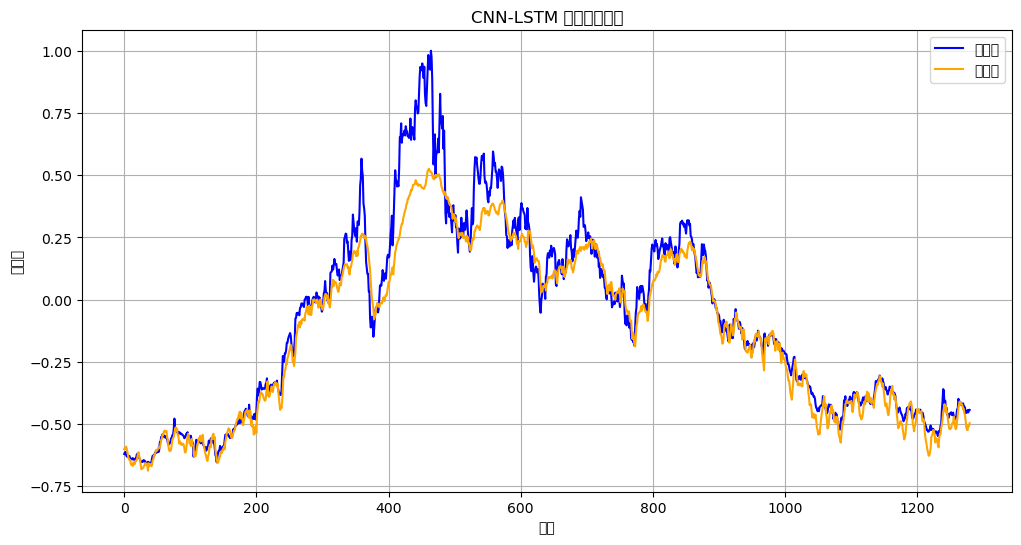

D:\temp\ipykernel_19584\959715397.py:206: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.savefig('cnn_lstm_loss.png', dpi=300, bbox_inches='tight')
D:\temp\ipykernel_19584\959715397.py:206: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.savefig('cnn_lstm_loss.png', dpi=300, bbox_inches='tight')
D:\temp\ipykernel_19584\959715397.py:206: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.savefig('cnn_lstm_loss.png', dpi=300, bbox_inches='tight')
D:\temp\ipykernel_19584\959715397.py:206: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  plt.savefig('cnn_lstm_loss.png', dpi=300, bbox_inches='tight')
D:\temp\ipykernel_19584\959715397.py:206: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from current font.
  plt.savefig('cnn_lstm_loss.png', dpi=300, bbox_inches='tight')
D:\temp\ipykernel_19584\959715397.py:206

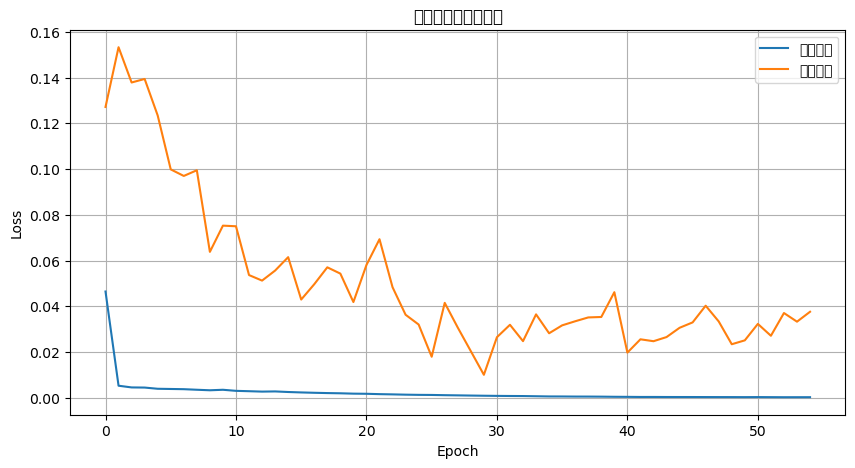

In [27]:
# 定义CNN-LSTM混合模型
class CNNLSTMModel(nn.Module):
    def __init__(self, input_channels=1, input_seq_length=10, input_features=3, 
                 conv_channels=32, lstm_hidden_size=64, num_lstm_layers=2, dropout=0.2):
        """
        CNN-LSTM混合模型，先用CNN提取特征，再用LSTM处理时序关系
        
        参数:
        input_channels: 输入的通道数
        input_seq_length: 输入序列长度，这里是时间步数量
        input_features: 每个时间步的特征数，这里是3个主成分
        conv_channels: CNN卷积层输出的通道数
        lstm_hidden_size: LSTM隐藏层的大小
        num_lstm_layers: LSTM层的数量
        dropout: Dropout比率，用于防止过拟合
        """
        super(CNNLSTMModel, self).__init__()
        
        self.input_channels = input_channels
        self.input_seq_length = input_seq_length
        self.input_features = input_features
        self.conv_channels = conv_channels
        self.lstm_hidden_size = lstm_hidden_size
        self.num_lstm_layers = num_lstm_layers
        
        # CNN部分 - 提取局部模式特征
        self.conv1 = nn.Conv2d(input_channels, conv_channels, kernel_size=(3, 3), padding=(1, 1))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))  # 在时间维度上降采样，保持特征维度
        
        # 计算CNN输出后的时间步长度
        self.cnn_output_seq_length = input_seq_length // 2  # 经过池化层，时间维度减半
        
        # 计算CNN输出后的特征维度
        self.cnn_output_features = conv_channels * input_features
        
        # LSTM部分 - 处理时序依赖关系
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_features,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0
        )
        
        # 全连接层 - 映射到输出
        self.fc = nn.Linear(lstm_hidden_size, 1)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # 添加通道维度 (batch_size, seq_len, features) -> (batch_size, channels, seq_len, features)
        x = x.unsqueeze(1)
        
        # CNN前向传播
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        # 重塑张量，准备输入LSTM
        # (batch_size, channels, cnn_output_seq_length, features) -> 
        # (batch_size, cnn_output_seq_length, channels*features)
        x = x.permute(0, 2, 1, 3)
        x = x.reshape(batch_size, self.cnn_output_seq_length, self.cnn_output_features)
        
        # LSTM前向传播
        h0 = torch.zeros(self.num_lstm_layers, batch_size, self.lstm_hidden_size).to(x.device)
        c0 = torch.zeros(self.num_lstm_layers, batch_size, self.lstm_hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # 只取最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 应用dropout
        lstm_out = self.dropout(lstm_out)
        
        # 全连接层映射到输出
        output = self.fc(lstm_out)
        
        return output.squeeze()  # 输出形状为(batch_size,)
model = CNNLSTMModel(
    input_channels=1,
    input_seq_length=10,  # 序列长度
    input_features=3,     # 3个主成分
    conv_channels=32,     # CNN卷积层通道数
    lstm_hidden_size=64,  # LSTM隐藏层大小
    num_lstm_layers=2,    # LSTM层数
    dropout=0.2           # Dropout比率
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # 添加L2正则化

# 添加学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# 训练模型
num_epochs = 200  # 增加epoch数量以获得更好的性能
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 25  # 提前停止的轮数
patience_counter = 0

# 打印模型结构
print(model)
print(f"模型总参数数量: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
    
    # 计算每个epoch的平均训练损失
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # 验证阶段
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)
        
        # 更新学习率调度器
        scheduler.step(val_loss)
        
        # 提前停止
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), 'best_cnn_lstm_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'提前停止训练！Epoch {epoch+1}')
                break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

# 加载最佳模型
model.load_state_dict(torch.load('best_cnn_lstm_model.pth'))

# 评估模型
model.eval()
with torch.no_grad():
    # 对训练集进行预测
    train_predictions = model(X_train_tensor).numpy()
    
    # 对测试集进行预测
    test_predictions = model(X_test_tensor).numpy()

# 计算评估指标
train_rmse = math.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_rmse = math.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("\n评估指标:")
print(f"训练集 - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, R²: {train_r2:.4f}")
print(f"测试集 - RMSE: {test_rmse:.3f}, MAE: {test_mae:.3f}, R²: {test_r2:.4f}")

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='实际值', color='blue')
plt.plot(test_predictions, label='预测值', color='orange')
plt.legend()
plt.title('CNN-LSTM 模型预测结果')
plt.xlabel('时间')
plt.ylabel('收盘价')
plt.grid(True)
plt.savefig('cnn_lstm_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

# 可视化训练和验证损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('训练和验证损失曲线')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('cnn_lstm_loss.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 定义CNN-LSTM混合模型
class CNNLSTM(nn.Module):
    def __init__(self, filters=34, kernel_size=2, lstm_units=68, dense_units=201):
        """
        CNN-LSTM混合模型，使用贝叶斯优化的超参数
        
        参数:
        filters: 卷积核个数，默认34
        kernel_size: 卷积核尺寸，默认2
        lstm_units: LSTM层神经元个数，默认68
        dense_units: Dense层神经元个数，默认201
        """
        super(CNNLSTM, self).__init__()
        
        # CNN部分
        self.cnn = nn.Sequential(
            nn.Conv2d(1, filters, kernel_size=(kernel_size, kernel_size), padding=(kernel_size//2, kernel_size//2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),  # 在时间维度上池化，保持特征维度
            nn.Flatten(start_dim=1)
        )
        
        # 计算CNN输出后的特征维度
        # 假设输入为(batch_size, 1, 10, 3)
        # 经过卷积后变为(batch_size, filters, 10, 3)
        # 经过池化后变为(batch_size, filters, 5, 3)
        # 展平后变为(batch_size, filters*5*3)
        cnn_output_size = filters * 5 * 3
        
        # LSTM部分
        self.lstm = nn.LSTM(
            input_size=cnn_output_size, 
            hidden_size=lstm_units,
            num_layers=1,
            batch_first=True
        )
        
        # 全连接输出层
        self.fc = nn.Sequential(
            nn.Linear(lstm_units, dense_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(dense_units, 1)
        )
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # 添加通道维度 (batch_size, seq_len, features) -> (batch_size, 1, seq_len, features)
        x = x.unsqueeze(1)
        
        # CNN前向传播
        cnn_out = self.cnn(x)
        
        # 重塑为LSTM输入 (batch_size, cnn_output_size) -> (batch_size, 1, cnn_output_size)
        lstm_in = cnn_out.unsqueeze(1)
        
        # LSTM前向传播
        lstm_out, _ = self.lstm(lstm_in)
        
        # 取最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 全连接层映射到输出
        output = self.fc(lstm_out)
        
        return output.squeeze()
# =================贝叶斯优化=================
# 定义模型训练评估函数 - 用于贝叶斯优化
def train_evaluate_model(learning_rate, filters, kernel_size, lstm_units, dense_units):
    """
    训练和评估模型，用于贝叶斯优化
    
    参数:
    learning_rate: 学习率
    filters: 卷积核个数
    kernel_size: 卷积核尺寸
    lstm_units: LSTM层神经元个数
    dense_units: Dense层神经元个数
    
    返回:
    r2: R²评分，越高越好(贝叶斯优化默认最大化目标函数)
    """
    # 转换整数参数
    filters = int(filters)
    kernel_size = int(kernel_size)
    lstm_units = int(lstm_units)
    dense_units = int(dense_units)
    
    # 创建模型
    model = CNNLSTM(filters=filters, kernel_size=kernel_size, 
                   lstm_units=lstm_units, dense_units=dense_units)
    
    # 使用已准备好的训练数据
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 简化训练过程，只训练少量epoch用于优化
    num_epochs = 20
    batch_size = 32
    
    # 创建数据加载器
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # 评估模型
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor).numpy()
    
    # 计算R²评分
    r2 = r2_score(y_test.ravel(), val_outputs.ravel())
    
    return r2

print("开始贝叶斯优化超参数...")
# 定义超参数空间
pbounds = {
    'learning_rate': (0.0001, 0.01),
    'filters': (2, 100),
    'kernel_size': (1, 2),
    'lstm_units': (2, 100),
    'dense_units': (2, 500)
}

# 创建优化器
optimizer = BayesianOptimization(
    f=train_evaluate_model,
    pbounds=pbounds,
    random_state=42
)

# 运行优化
optimizer.maximize(init_points=5, n_iter=10)

# 获取最佳参数
best_params = optimizer.max['params']
best_params['filters'] = int(best_params['filters'])
best_params['kernel_size'] = int(best_params['kernel_size'])
best_params['lstm_units'] = int(best_params['lstm_units'])
best_params['dense_units'] = int(best_params['dense_units'])

print("最佳超参数:", best_params)

# =================训练最终模型=================
# 使用最佳参数训练最终模型
final_model = CNNLSTM(
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    lstm_units=best_params['lstm_units'],
    dense_units=best_params['dense_units']
)

# 创建数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

# 训练最终模型
num_epochs = 150
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(num_epochs):
    # 训练阶段
    final_model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # 前向传播
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
    
    # 计算平均训练损失
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # 验证阶段
    final_model.eval()
    with torch.no_grad():
        val_outputs = final_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)
        
        # 提前停止
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(final_model.state_dict(), 'best_bo_cnn_lstm_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'提前停止训练！Epoch {epoch+1}')
                break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

# 加载最佳模型
final_model.load_state_dict(torch.load('best_bo_cnn_lstm_model.pth'))

# =================模型评估=================
# 评估模型
final_model.eval()
with torch.no_grad():
    # 对训练集进行预测
    train_predictions = final_model(X_train_tensor).numpy()
    
    # 对测试集进行预测
    test_predictions = final_model(X_test_tensor).numpy()

# 计算评估指标
train_rmse = math.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_rmse = math.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("\n评估指标:")
print(f"训练集 - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, R²: {train_r2:.4f}")
print(f"测试集 - RMSE: {test_rmse:.3f}, MAE: {test_mae:.3f}, R²: {test_r2:.4f}")

# =================可视化结果=================
# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='实际值', color='blue')
plt.plot(test_predictions, label='预测值', color='orange')
plt.legend()
plt.title('BO-CNN-LSTM 模型预测结果')
plt.xlabel('时间')
plt.ylabel('收盘价')
plt.grid(True)
plt.savefig('bo_cnn_lstm_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

# 可视化训练和验证损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('训练和验证损失曲线')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('bo_cnn_lstm_loss.png', dpi=300, bbox_inches='tight')
plt.show()